In [5]:
import random
import numpy as np
from numpy import linalg as LA
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.integrate import odeint
import itertools
import pandas as pd
from tqdm import tqdm
from numpy.polynomial import polynomial as P
import warnings
warnings.filterwarnings('ignore')
from experiments import PycnoSIX

### Get determinant value and max-eigenvalues of first patch

In [6]:
def get_jacobian_first_patch(r,k,beta_1,beta_2,alpha,mu_S,mu_I,JS1,AS1,JI1,AI1):

    N1 = JS1 + AS1 + JI1 + AI1
    delta_1 = (JI1 + AI1)/N1
    eta_1 = (JI1 + AI1)/(N1**2)
    vartheta_1 = (JS1 + AS1)/(N1**2) # I was missing a **2 here!

    # Corrected version:
    J1 = np.array([
        [-1*(p*r*AS1)/(k) - beta_1*delta_1 + beta_1*JS1*eta_1 - (alpha+mu_S), -1*(p*r*AS1)/(k) - beta_1*JS1*vartheta_1, 
         p*r*(1-((N1+AS1)/k)) + beta_1*JS1*eta_1, -1*(p*r*AS1)/(k) - beta_1*JS1*vartheta_1],
        [beta_1*delta_1 - beta_1*JS1*eta_1, beta_1*JS1*vartheta_1 - mu_I, -1*beta_1*JS1*eta_1, beta_1*JS1*vartheta_1],
        [alpha + beta_1*AS1*eta_1, -1*beta_1*AS1*vartheta_1, -1*beta_1*delta_1 + beta_1*AS1*eta_1 - mu_S, -1*beta_1*AS1*vartheta_1],
        [-1*beta_1*AS1*eta_1, beta_1*AS1*vartheta_1, beta_1*delta_1 - beta_1*AS1*eta_1, beta_1*AS1*vartheta_1 - mu_I]
    ])

    eigenvalues, eigenvectors = LA.eig(J1)
    return eigenvalues

def get_jacobian_second_patch(r,k,beta_1,beta_2,alpha,mu_S,mu_I,AS1,JS2,AS2,JI2,AI2):

    N2 = JS2 + AS2 + JI2 + AI2
    delta_2 = (JI2 + AI2)/N2
    eta_2 = (JI2 + AI2)/(N2**2)
    vartheta_2 = (JS2 + AS2)/(N2**2) # I was missing a **2 here!

    # Corrected version as well:
    J2 = np.array([
        [-1*(p*r*AS2)/(k) - beta_2*delta_2 + beta_2*JS2*eta_2 - (alpha+mu_S) - ((1-p)*r*AS1)/(k), -1*(p*r*AS2)/(k) - beta_2*JS2*vartheta_2 - ((1-p)*r*AS1)/(k), 
         p*r*(1-((N2+AS2)/k)) + beta_2*JS2*eta_2 - ((1-p)*r*AS1)/(k), -1*(p*r*AS2)/(k) - beta_2*JS2*vartheta_2 - ((1-p)*r*AS1)/(k)],
        [beta_2*delta_2 - beta_2*JS2*eta_2, beta_2*JS2*vartheta_2 - mu_I, -1*beta_2*JS2*eta_2, beta_2*JS2*vartheta_2],
        [alpha + beta_2*AS2*eta_2, -1*beta_2*AS2*vartheta_2, -1*beta_2*delta_2 + beta_2*AS2*eta_2 - mu_S, -1*beta_2*AS2*vartheta_2],
        [-1*beta_2*AS2*eta_2, beta_2*AS2*vartheta_2, beta_2*delta_2 - beta_2*AS2*eta_2, beta_2*AS2*vartheta_2 - mu_I]
    ])
    eigenvalues, eigenvectors = LA.eig(J2)
    return eigenvalues

### Equilibrium in terms of $R_0^1$
Figure #2

In [7]:
def get_equilibrium_in_terms_of_R0_1(r,k,beta_2,alpha,mu_S,mu_I,t_max,p,num_sim):

    beta_1s = np.linspace(0.05, 0.8, 501)
    R1s_use = []

    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []

    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []

    eig_obtaineds_1 = []
    max_eig_obtaineds_1 = []
    
    R_p = p/mu_I
    R_alpha = alpha/mu_I
    R_s = mu_S/mu_I

    root_1 = 1 - R_s + (R_alpha/2)*(-1 - np.sqrt(1+ 4*r*R_p/R_alpha)) 
    root_2 = 1 - R_s + (R_alpha/2)*(-1 + np.sqrt(1+ 4*r*R_p/R_alpha)) 

    print(f'root 1: {root_1}, root 2: {root_2}')

    for beta_1 in tqdm(beta_1s):
        for _ in range(num_sim):
            
            try:

                # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
                x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

                new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
                new_pycno.solve_odes_system_odeint()

                I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
                I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]

                S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
                S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

                eigs1 = get_jacobian_first_patch(r, k, beta_1, 
                                                 beta_2, alpha,
                                                 mu_S, mu_I,
                                                 JS1=new_pycno.Js1[-1], AS1=new_pycno.As1[-1], ### Fixed!
                                                 JI1=new_pycno.Ji1[-1], AI1=new_pycno.Ai1[-1])

                if np.max(eigs1) < 0:

                    R1s_use.append(beta_1/mu_I)
                    
                    I_eq_obtaineds_1.append(I_eq_obtained_1)
                    I_eq_obtaineds_2.append(I_eq_obtained_2)
    
                    S_eq_obtaineds_1.append(S_eq_obtained_1)
                    S_eq_obtaineds_2.append(S_eq_obtained_2)
    
                    eig_obtaineds_1.append(eigs1)
                    max_eig_obtaineds_1.append(np.max(eigs1))
                    
            except Exception as e:
                # print(f'{e} at {beta_1}')
                pass

    return R1s_use, I_eq_obtaineds_1, I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2, max_eig_obtaineds_1, eig_obtaineds_1

In [8]:
r = 1
k = 1

mu_S = 0.1
mu_I = 0.1
t_max = 5000

alpha = 0.6
p = 0.5

beta_2 = 0.4
R_0_2 = beta_2/mu_I
print(R_0_2)

num_sim = 10
R1s_use, I_eq_obtaineds_1, I_eq_obtaineds_2, \
S_eq_obtaineds_1, S_eq_obtaineds_2, \
max_eig_obtaineds_1, eig_obtaineds_1 = get_equilibrium_in_terms_of_R0_1(r,k,beta_2, alpha,mu_S, mu_I,t_max,p,num_sim)

4.0
root 1: -9.244997998398398, root 2: 3.2449979983983988


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:33<00:00, 14.74it/s]


In [10]:
new_max_eigs = []
for idx, val in enumerate(I_eq_obtaineds_1[0:nn]):
    if (idx > 1000) and (np.abs(val) < 1e-4):
        new_max_eigs.append(-0.1)
    else:
        new_max_eigs.append(np.real(max_eig_obtaineds_1[0:nn][idx]))
# Fixing some issues in eigenvalues at extinction which are due to numerical inconsistency

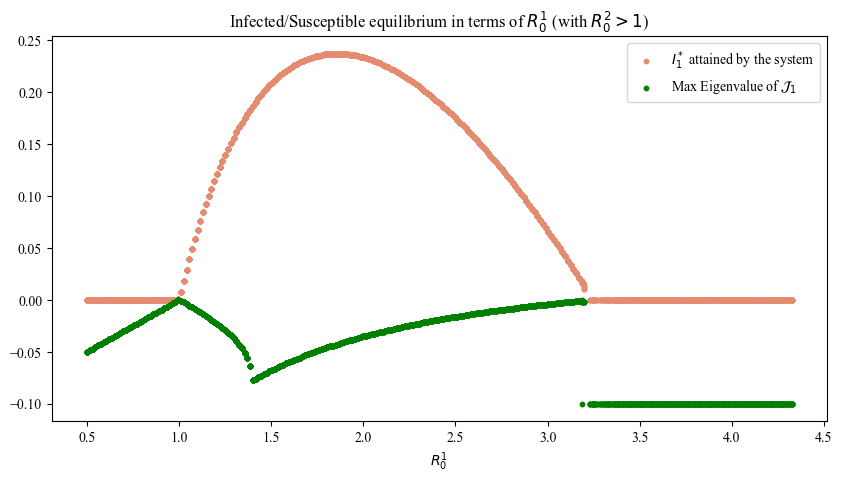

In [11]:
# Figure 4 Panel a)

fig = plt.figure()
ax1 = fig.add_subplot(111)

nn = 2500

ax1.scatter(R1s_use[0:nn], I_eq_obtaineds_1[0:nn], s=10, marker='o', color='#E58C70', label=r'$I_1^*$ attained by the system')
ax1.scatter(R1s_use[0:nn], new_max_eigs, s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_1$')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^1$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^1$ (with $R_0^2>1$)")
plt.show()

In [78]:
# print(f"""
# R01s = {{ {','.join([str(round(x,4)) for x in R1s_use[0:nn]])} }}; \n
# infP1 = {{ {','.join([str(round(x,4)) for x in I_eq_obtaineds_1[0:nn]])} }}; \n
# maxeigs1 = {{ {','.join([str(round(x,4)) for x in new_max_eigs])} }}; \n
# """)

In [12]:
# Verifying eigenvalues at DFE:
beta_1 = 0.08
print(f'R_0,1 = {beta_1/mu_I}')
x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
new_pycno.solve_odes_system_odeint()
eigs1 = get_jacobian_first_patch(r, k, beta_1, beta_2, alpha, mu_S, mu_I,
                                                    JS1=new_pycno.Js1[-1], AS1=new_pycno.As1[-1],
                                                    JI1=new_pycno.Ji1[-1], AI1=new_pycno.Ai1[-1])
print(beta_1 - mu_I)
print(eigs1)
print(np.max(eigs1))

R_0,1 = 0.7999999999999999
-0.020000000000000004
[-0.86163798 -0.26693345 -0.1        -0.02      ]
-0.01999999999999858


In [33]:
def get_equilibrium_in_terms_of_R0_2(r,k,beta_1,alpha,mu_S,mu_I,t_max,p,num_sim):

    beta_2s = np.linspace(0.05, 0.8, 501)
    R2s_use = []

    I_eq_obtaineds_2 = []
    S_eq_obtaineds_2 = []
    eig_obtaineds_2 = []
    max_eig_obtaineds_2 = []

    R_p = p/mu_I
    R_alpha = alpha/mu_I
    R_s = mu_S/mu_I

    for beta_2 in tqdm(beta_2s):
        
        for _ in range(num_sim):
            
            try:

                # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
                x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

                new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
                new_pycno.solve_odes_system_odeint()

                I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
                S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

                eigs2 = get_jacobian_second_patch(r, k, beta_1, beta_2, alpha,
                                                  mu_S, mu_I, AS1= new_pycno.As1[-1],
                                                  JS2=new_pycno.Js2[-1], AS2=new_pycno.As2[-1], ### Fixed!
                                                  JI2=new_pycno.Ji2[-1], AI2=new_pycno.Ai2[-1])

                if np.max(eigs2) < 0:

                    R2s_use.append(beta_2/mu_I)
                    
                    I_eq_obtaineds_2.append(I_eq_obtained_2)
                    S_eq_obtaineds_2.append(S_eq_obtained_2)
                    eig_obtaineds_2.append(eigs2)
                    max_eig_obtaineds_2.append(np.max(eigs2))
                    
            except Exception as e:
                print(f'Error: {e} at {beta_2}')
                pass

    return R2s_use, I_eq_obtaineds_2, S_eq_obtaineds_2, max_eig_obtaineds_2, eig_obtaineds_2

In [34]:
r = 1
k = 1

mu_S = 0.1
mu_I = 0.1
t_max = 5000

alpha = 0.6
p = 0.5

num_sim = 10

beta_1 = 0.5*mu_I
print(beta_1)
R2s_use_0, I_eq_obtaineds_2_0, S_eq_obtaineds_2_0, max_eig_obtaineds_2_0, eig_obtaineds_2_0 = get_equilibrium_in_terms_of_R0_2(r,k,beta_1,alpha,mu_S,mu_I,t_max,p,num_sim)

beta_1 = 2.5*mu_I
print(beta_1)
R2s_use_1, I_eq_obtaineds_2_1, S_eq_obtaineds_2_1, max_eig_obtaineds_2_1, eig_obtaineds_2_1 = get_equilibrium_in_terms_of_R0_2(r,k,beta_1,alpha,mu_S,mu_I,t_max,p,num_sim)

beta_1 = 3.5*mu_I
print(beta_1)
R2s_use_2, I_eq_obtaineds_2_2, S_eq_obtaineds_2_2, max_eig_obtaineds_2_2, eig_obtaineds_2_2 = get_equilibrium_in_terms_of_R0_2(r,k,beta_1,alpha,mu_S,mu_I,t_max,p,num_sim)

0.05


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:35<00:00, 14.04it/s]


0.25


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [01:06<00:00,  7.50it/s]


0.35000000000000003


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [01:03<00:00,  7.94it/s]


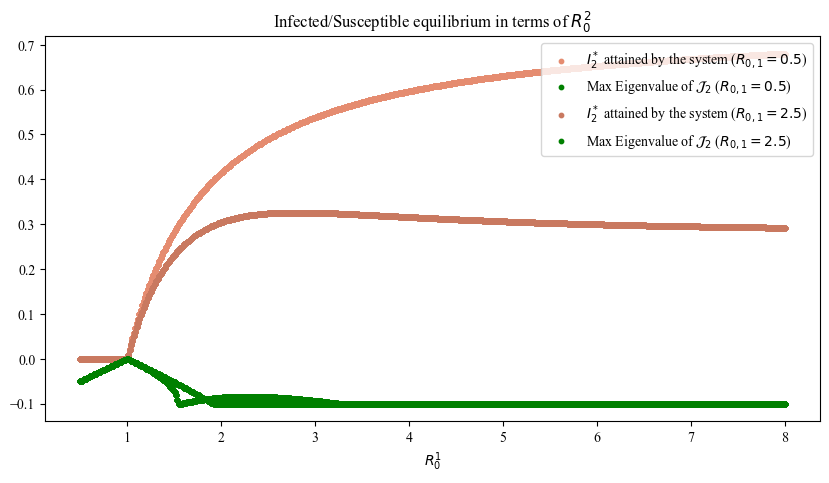

In [43]:
# Figure 4 Panel b)

fig = plt.figure()
ax1 = fig.add_subplot(111)

nn = 2500

ax1.scatter(R2s_use_0, I_eq_obtaineds_2_0, s=10, marker='o', color='#E58C70', label=r'$I_2^*$ attained by the system ($R_{0,1}=0.5$)')
ax1.scatter(R2s_use_0, max_eig_obtaineds_2_0, s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_2$ ($R_{0,1}=0.5$)')

ax1.scatter(R2s_use_1, I_eq_obtaineds_2_1, s=10, marker='o', color='#C97960', label=r'$I_2^*$ attained by the system ($R_{0,1}=2.5$)')
ax1.scatter(R2s_use_1, max_eig_obtaineds_2_1, s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_2$ ($R_{0,1}=2.5$)')

# ax1.scatter(R2s_use_2, I_eq_obtaineds_2_2, s=10, marker='o', color='#AE6954', label=r'$I_2^*$ attained by the system ($R_{0,1}=3.5$)')
# ax1.scatter(R2s_use_2, max_eig_obtaineds_2_2, s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_2$ ($R_{0,1}=3.5$)')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^1$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^2$")
plt.show()

## Equilibriums in terms of both $R_0^1$ and $R_0^2$
Figure #3

In [167]:
beta_1s = np.linspace(0.05, 0.8, 51)
beta_2s = np.linspace(0.05, 0.8, 51)

r = 1
k = 1
mu_S = 0.1
mu_I = 0.1

# alpha = 0.6
# p = 0.5

alpha = 0.6
p = 0.5

t_max = 2000
num_sim = 10

combs = list(itertools.product(beta_1s, beta_2s))

dat_ = pd.DataFrame({})

for comb in tqdm(combs):

    beta_1 = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)

    dat_ = pd.concat([dat_, pd.DataFrame({
        'R_0_1' : [round(beta_1/mu_I,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2601/2601 [07:14<00:00,  5.98it/s]


In [168]:
# dat_0 = dat_.copy()
# dat_0.to_csv('./dat00.csv', index=False)

In [169]:
plot1_data = dat_.pivot(index='R_0_1', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))
data1 = np.flip(data, axis=0)

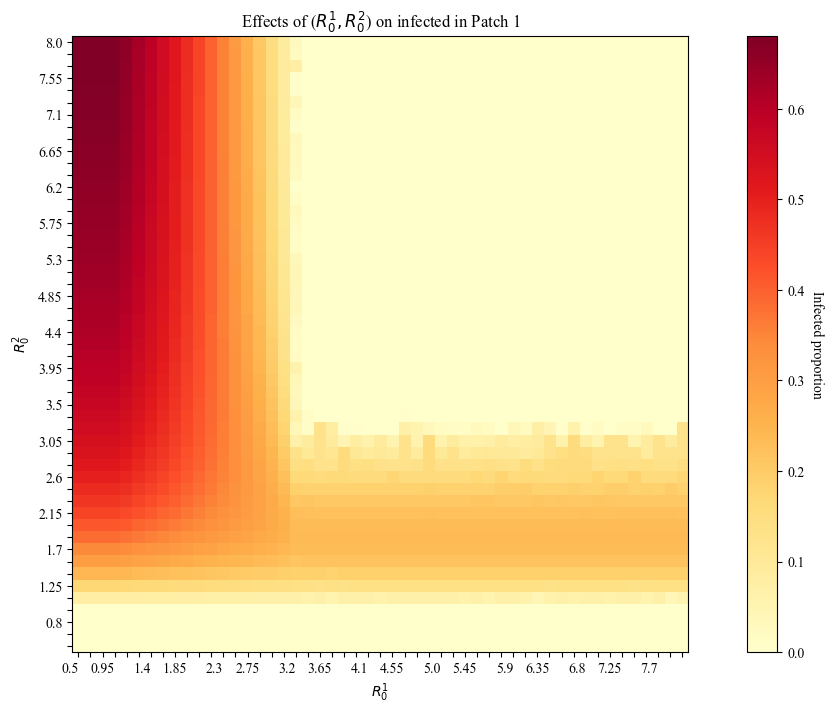

In [170]:
# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data1, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))

# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs[::-1])

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Infected proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on infected in Patch 1")
plt.xlabel("$R_0^1$")
plt.ylabel("$R_0^2$")
plt.show()

In [173]:
# xlabs = list(plot1_data.index)
# ylabs = plot1_data.columns.tolist()

# print(','.join([f"{{{i+1},Rotate[{x}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))
# print(','.join([f"{{{i+1},{x}}}" for i, x in enumerate(ylabs[::-1]) if i%2 == 0]))

# for dat in data1:
#     print(f"{{ {','.join([f'{d:.8f}' for d in dat])} }},")

## Third root of $I_1$ is not greater than 1.
This is a special case, completely different than the previous case. It occurs for example, when the parameter $\alpha$ is very small.

In [ ]:
beta_2 = 0.3
alpha = 0.02
t_max = 5000

R1s_use, I_1_theoreticals, I_eq_obtaineds_1, \
I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2 = get_equilibrium_in_terms_of_R0_1(r,k,beta_2,
                                                                                        alpha,mu_S,
                                                                                        mu_I,t_max,p,num_sim)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(R1s_use, I_eq_obtaineds_1, s=10, marker='o', color='#E58C70', label=r'$I_1^*$ attained by the system')
ax1.scatter(R1s_use, I_eq_obtaineds_2, s=10, marker='o', color='#C74B24', label=r'$I_2^*$ attained by the system')

ax1.scatter(R1s_use, S_eq_obtaineds_1, s=10, marker='o', color='#689CDE', label=r'$S_1^*$ attained by the system')
ax1.scatter(R1s_use, S_eq_obtaineds_2, s=10, marker='o', color='#246AC4', label=r'$S_2^*$ attained by the system')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^1$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^1$ (with $R_0^2<1$)")
plt.show()

### Effect of $\alpha$

In [ ]:
# print(f"""
# alphas =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in alphas_use])} }};
# I1s =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in I_eq_obtaineds_1])} }};
# I2s =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in I_eq_obtaineds_2])} }};
# """)

In [43]:
beta_1 = 0.25
beta_2s = np.linspace(0.05, 0.8, 51)
alphas = np.linspace(0.001, 1, 51)

r = 1
k = 1

mu_S = 0.1
mu_I = 0.1

alpha = 0.6
p = 0.5

t_max = 2000
num_sim = 10

combs = list(itertools.product(alphas, beta_2s))

dat_ = pd.DataFrame({})

for comb in tqdm(combs):

    alpha = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)

    dat_ = pd.concat([dat_, pd.DataFrame({
        'alpha' : [round(alpha,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2601/2601 [10:54<00:00,  3.97it/s]


In [44]:
# dat0_alphas = dat_.copy()
# dat0_alphas.to_csv('data_alphas.csv', index=False)

In [45]:
dat_ = pd.read_csv('data_alphas.csv')

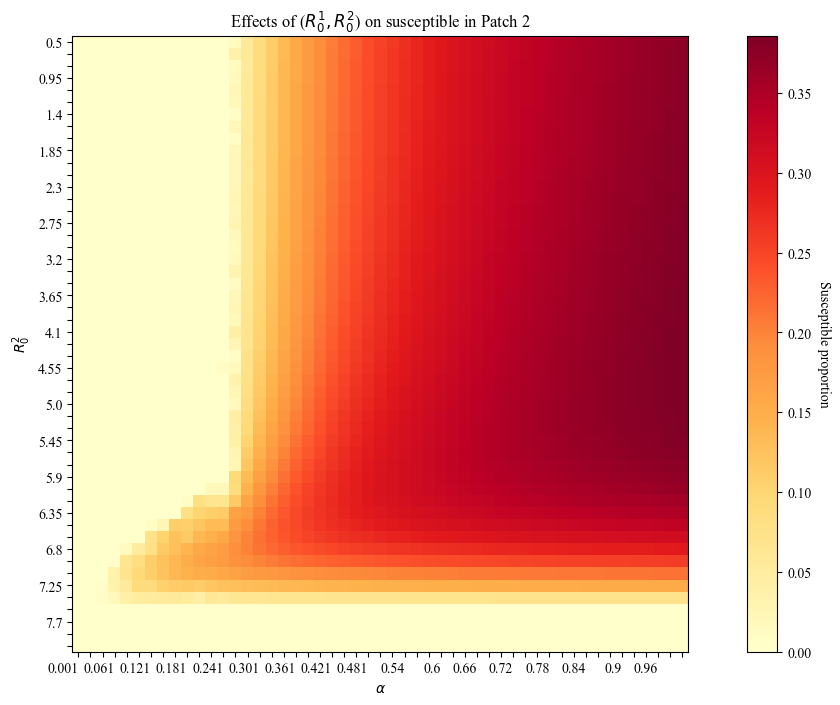

In [47]:
plot1_data = dat_.pivot(index='alpha', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Pivot for version #2 of article
data = np.flip(data, axis=0)

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Susceptible proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on susceptible in Patch 2")
plt.xlabel("$\\alpha$")
plt.ylabel("$R_0^2$")
plt.show()

In [52]:
# print(','.join([f"{{{i+1},Rotate[{x}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))
# print('---')
# print(','.join([f"{{{i+1},{y}}}" for i, y in enumerate(ylabs[::-1]) if i%2 == 0]))
# for dat in data:
#     print(f"{{ {','.join([f'{d:.4f}' for d in dat])} }},")

### Effect of $p$

In [53]:
beta_1 = 0.25
beta_2s = np.linspace(0.05, 0.8, 51)
pps_ = np.linspace(0.001, 1, 51)

r = 1
k = 1
alpha = 0.6
mu_S = 0.1
mu_I = 0.1

t_max = 2000
num_sim = 10

combs = list(itertools.product(pps_, beta_2s))

datp_ = pd.DataFrame({})

for comb in tqdm(combs):

    p = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)
    datp_ = pd.concat([datp_, pd.DataFrame({
        'p' : [round(p,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2601/2601 [03:54<00:00, 11.10it/s]


In [55]:
dat0_pps = datp_.copy()
dat0_pps.to_csv('data_pps.csv', index=False)

In [ ]:
# datp_ = pd.read_csv('data_pps.csv')

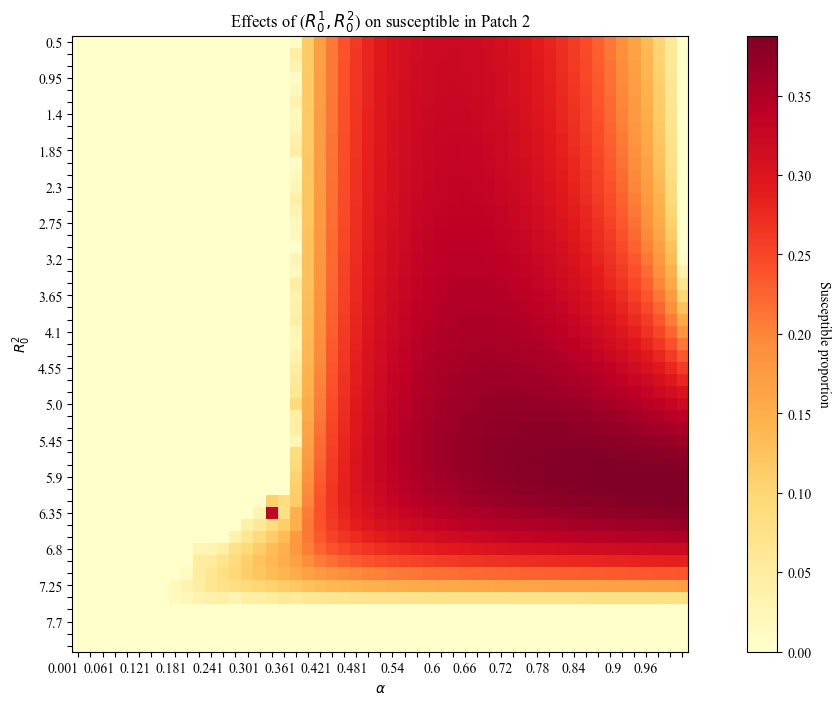

In [57]:
plot1_data = datp_.pivot(index='p', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Pivot for version #2 of article
data = np.flip(data, axis=0)

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Susceptible proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on susceptible in Patch 2")
plt.xlabel("$\\alpha$")
plt.ylabel("$R_0^2$")
plt.show()

In [ ]:
# for dat in data:
#     print(f"{{ {','.join([f'{d:.4f}' for d in dat])} }},")
# xlabs = list(plot1_data.index)
# ylabs = list(plot1_data.columns)
# print(','.join([f"{{{i+1},Rotate[{round(x,2)}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))
# print(','.join([f"{{{i+1}, {round(y,2)} }}" for i, y in enumerate(ylabs[::-1]) if i%2 == 0]))